### 1. Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

### 2. Data import

In [2]:
df = pd.read_csv('input/new_churn_data.csv')

### 3. Data preparation

In [4]:
user_identifier = df['user']

In [5]:
df = df.drop(columns = 'user')

#### 3.1. One-Hot Encoding

In [6]:
df['housing'].value_counts()

na    13856
R     10969
O      2171
Name: housing, dtype: int64

In [7]:
df = pd.get_dummies(df)

In [10]:
df.columns #all categotical variables were spread

Index(['churn', 'age', 'deposits', 'withdrawal', 'purchases_partners',
       'purchases', 'cc_taken', 'cc_recommended', 'cc_disliked', 'cc_liked',
       'cc_application_begin', 'app_downloaded', 'web_user', 'ios_user',
       'android_user', 'registered_phones', 'waiting_4_loan', 'cancelled_loan',
       'received_loan', 'rejected_loan', 'left_for_two_month_plus',
       'left_for_one_month', 'reward_rate', 'is_referred', 'housing_O',
       'housing_R', 'housing_na', 'payment_type_Bi-Weekly',
       'payment_type_Monthly', 'payment_type_Semi-Monthly',
       'payment_type_Weekly', 'payment_type_na', 'zodiac_sign_Aquarius',
       'zodiac_sign_Aries', 'zodiac_sign_Cancer', 'zodiac_sign_Capricorn',
       'zodiac_sign_Gemini', 'zodiac_sign_Leo', 'zodiac_sign_Libra',
       'zodiac_sign_Pisces', 'zodiac_sign_Sagittarius', 'zodiac_sign_Scorpio',
       'zodiac_sign_Taurus', 'zodiac_sign_Virgo', 'zodiac_sign_na'],
      dtype='object')

In [11]:
df = df.drop(columns = ['housing_na', 'zodiac_sign_na', 'payment_type_na']) #remove non-informative columns

#### 3.2. Splitting into training and testing dataset

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'churn'),
                                                   df['churn'],
                                                   test_size = 0.2,
                                                   random_state = 0)

#### 3.3. Balancing training set

In [17]:
y_train.value_counts()

0    12656
1     8940
Name: churn, dtype: int64

In [18]:
pos_index = y_train[ y_train.values == 1 ].index
neg_index = y_train[ y_train.values == 0 ].index

In [19]:
if len(pos_index) > len(neg_index):
    higher = pos_index
    lower = neg_index
else:
    higher = neg_index
    lower = pos_index

In [20]:
random.seed(0)
higher = np.random.choice(higher, size = len(lower))
new_indexes = np.concatenate((lower, higher))

X_train = X_train.loc[new_indexes, ]
y_train = y_train[new_indexes]

#### 3.4. Feature scaling

In [21]:
from sklearn.preprocessing import StandardScaler

In [24]:
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.fit_transform(X_test))

X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values

X_train2.index = X_train.index.values
X_test2.index = X_test.index.values

X_train = X_train2
X_test = X_test2

### 4. Model Building

#### 4.1. Fitting Model to Training Set

In [25]:
from sklearn.linear_model import LogisticRegression

In [60]:
classifier = LogisticRegression(random_state = 0, solver = 'lbfgs')

In [61]:
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

####  4.2. Predicting Test Set

In [62]:
y_pred = classifier.predict(X_test)

#### 4.3. Evaluating Results

In [63]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [64]:
cm = confusion_matrix(y_test, y_pred)

In [65]:
accuracy_score(y_test, y_pred)

0.6109259259259259

In [66]:
precision_score(y_test, y_pred)

0.5204804434862951

In [67]:
recall_score(y_test, y_pred)

0.756490599820949

In [68]:
f1_score(y_test, y_pred)

0.6166757890895822

Test Data Accuracy: 0.6109


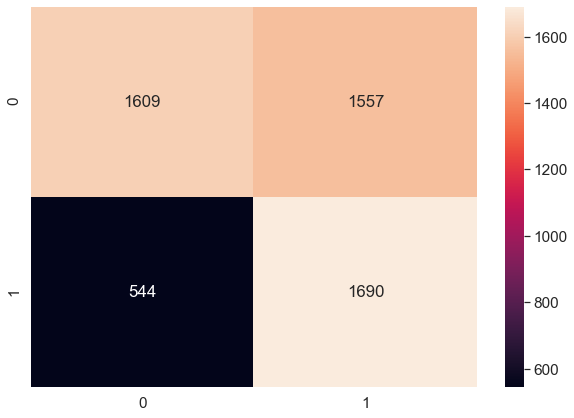

In [69]:
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10, 7))
sns.set(font_scale = 1.4)
sns.heatmap(df_cm, annot = True, fmt = 'g')
print('Test Data Accuracy: %0.4f' % accuracy_score(y_test, y_pred))

#### 4.4. Applying k-Fold Cross Validation

In [70]:
from sklearn.model_selection import cross_val_score

In [71]:
accuracies = cross_val_score(estimator = classifier,
                            X = X_train,
                            y = y_train,
                            cv = 10)

In [72]:
accuracies

array([0.64038031, 0.64485459, 0.66219239, 0.62863535, 0.62304251,
       0.65044743, 0.651566  , 0.63255034, 0.64261745, 0.6442953 ])

In [73]:
accuracies.mean()

0.6420581655480985

#### 4.5. Analyzing Coefficients

In [74]:
pd.concat([pd.DataFrame(X_train.columns, columns = ['features']),
          pd.DataFrame(np.transpose(classifier.coef_), columns = ['coef'])],
         axis = 1)

,features,coef
0,age,-0.168074
1,deposits,0.238621
2,withdrawal,0.033068
3,purchases_partners,-0.720571
4,purchases,-0.360234
5,cc_taken,0.059923
6,cc_recommended,0.033103
7,cc_disliked,0.001263
8,cc_liked,-0.011816
9,cc_application_begin,0.040638


### 5. Feature Selection

In [42]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

#### 5.1. Model to Test

In [48]:
classifier = LogisticRegression(solver = 'lbfgs')

In [49]:
rfe = RFE(classifier, 20)
rfe = rfe.fit(X_train, y_train)

#### 5.2. Summarize attributes selection

In [51]:
print(rfe.support_) #map which columns are included in final results

[ True  True  True  True  True  True False False False  True False  True
  True False  True  True  True  True  True  True  True  True False  True
  True False False False  True False False False False False False False
 False False False False False]


In [56]:
X_train.columns[rfe.support_] #print 20 features that are best to be used acc. to the model

Index(['age', 'deposits', 'withdrawal', 'purchases_partners', 'purchases',
       'cc_taken', 'cc_application_begin', 'web_user', 'ios_user',
       'registered_phones', 'waiting_4_loan', 'cancelled_loan',
       'received_loan', 'rejected_loan', 'left_for_two_month_plus',
       'left_for_one_month', 'reward_rate', 'housing_O', 'housing_R',
       'payment_type_Weekly'],
      dtype='object')

In [57]:
rfe.ranking_ #ones means that features were included and 2 or above - not included, with no. 2 as most important from those not included

array([ 1,  1,  1,  1,  1,  1,  6, 22, 19,  1, 21,  1,  1,  9,  1,  1,  1,
        1,  1,  1,  1,  1,  5,  1,  1,  2,  3,  4,  1, 10, 11, 17, 20, 14,
        8, 13, 18, 16,  7, 12, 15])

#### 5.3. Predicting Test Set

In [83]:
classifier = LogisticRegression(random_state = 0, solver = 'lbfgs')
classifier.fit(X_train[X_train.columns[rfe.support_]], y_train)
y_pred = classifier.predict(X_test[X_train.columns[rfe.support_]])

#### 5.4. Evaluating Results

In [84]:
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)

(0.6079629629629629,
 0.5179723502304148,
 0.7547000895255148,
 0.6143195481872837)

Test Data Accuracy: 0.6080


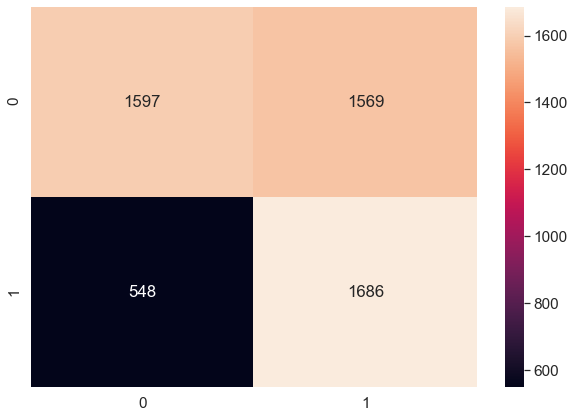

In [82]:
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10, 7))
sns.set(font_scale = 1.4)
sns.heatmap(df_cm, annot = True, fmt = 'g')
print('Test Data Accuracy: %0.4f' % accuracy_score(y_test, y_pred))

We realised that there are a lot of columns that are not useful in our model. This is validated by showing that the results for both cases are similiar.

#### 5.5. Analyzing Coefficients

In [85]:
pd.concat([pd.DataFrame(X_train.columns[rfe.support_], columns = ['features']),
          pd.DataFrame(np.transpose(classifier.coef_), columns = ['coef'])],
         axis = 1)

,features,coef
0,age,-0.168266
1,deposits,0.243663
2,withdrawal,0.035074
3,purchases_partners,-0.696142
4,purchases,-0.361975
5,cc_taken,0.058525
6,cc_application_begin,0.047574
7,web_user,0.120999
8,ios_user,0.072994
9,registered_phones,0.120647


#### 5.6. Formatting Final Results

In [87]:
final_results = pd.concat([y_test, user_identifier], axis=1).dropna()
final_results['predicted_churn'] = y_pred
final_results = final_results[['user', 'churn', 'predicted_churn']].reset_index(drop=True)
final_results

,user,churn,predicted_churn
0,61353,1.0,1
1,67679,0.0,0
2,21269,0.0,0
3,69531,0.0,1
4,25997,0.0,0
...,...,...,...
5395,22377,0.0,1
5396,24291,1.0,1
5397,23740,0.0,1
5398,47663,1.0,0
